In [1]:
import pandas as pd
import numpy as np
import urllib.request

import seaborn as sns

# Reading Data

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'
filename = 'data.csv'
urllib.request.urlretrieve(url, filename)

('data.csv', <http.client.HTTPMessage at 0x2059e427df0>)

In [3]:
df = pd.read_csv('data.csv', header=0, sep=',')
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


# Exploratory Data Analysis

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

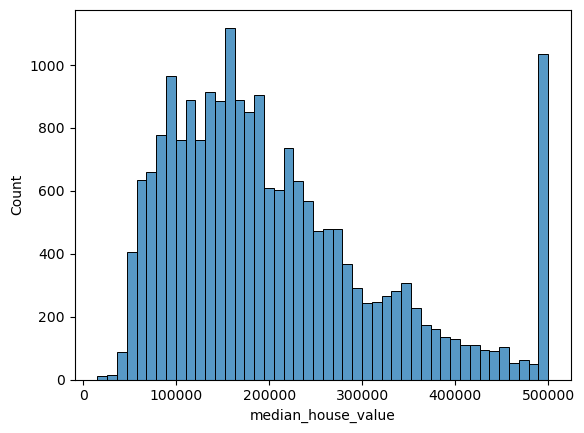

In [4]:
sns.histplot(df.median_house_value)

In [5]:
df = df[[
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
    ]]
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


## Q1. Find a feature with missing values. How many missing values does it have?

In [6]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Q2. What's the median (50% percentile) for variable 'population'?

In [7]:
df['population'].median()

1166.0

# Validation framework

In [8]:
# create train, validation and test feature matrixes

n = len(df)    # size of dataframe

n_val = int(0.2 * n)    # size of validation dataframe
n_test = int(0.2 * n)    # size of test dataframe
n_train = n - (n_val + n_test)    # size of train dataframe

np.random.seed(42)

idx = np.arange(n)    # list of indexes
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]    # create shuffled dataframe from initial

df_train = df_shuffled.iloc[:n_train].reset_index(drop = True)    # create train dataframe and reset indexes
df_val = df_shuffled.iloc[n_train:n_train+n_val].reset_index(drop = True)
df_test = df_shuffled.iloc[n_train+n_val:].reset_index(drop = True)

In [9]:
# create train, validation and test target arrays

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']    # delete target from feature matrix
del df_val['median_house_value']
del df_test['median_house_value']

# Linear Regression

In [10]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [11]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

## Q3. Fill 'total_bedrooms' with 0 or with the mean of this variable. Train a linear regression model without regularization. Calculate RMSE. Which option gives a better RMSE?

In [12]:
def prepare_X(df, fill_num):
    df_num = df.fillna(fill_num)
    X = df_num.values
    return X

In [13]:
def eval_linear_regression(df_train, y_train, df_val, y_val, fill_num):
    X_train = prepare_X(df_train, fill_num)
    X_val = prepare_X(df_val, fill_num)
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)
    return rmse(y_val, y_pred)

In [14]:
score = eval_linear_regression(df_train, y_train, df_val, y_val, 0)
round(score, 2)

0.33

In [15]:
mean_train = df_train['total_bedrooms'].mean()
score = eval_linear_regression(df_train, y_train, df_val, y_val, mean_train)
round(score, 2)

0.33

In [16]:
median_train = df_train['total_bedrooms'].median()
score = eval_linear_regression(df_train, y_train, df_val, y_val, median_train)
round(score, 2)

0.33

# Regularized Linear Regression

In [17]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

## Q4. Train a regularized linear regression. Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]. Which r gives the best RMSE?

In [18]:
r = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [19]:
for reg_par in r:
    X_train = prepare_X(df_train, 0)
    X_val = prepare_X(df_val, 0)
    w0, w = train_linear_regression_reg(X_train, y_train, reg_par)
    y_pred = w0 + df_val.dot(w)
    rmse_r = rmse(y_val, y_pred)
    print(reg_par,"    ", round(rmse_r, 2))

0      0.33
1e-06      0.33
0.0001      0.33
0.001      0.33
0.01      0.33
0.1      0.33
1      0.33
5      0.34
10      0.34


## Q5. Find out how selecting the seed influences our score. Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]. For each seed, do the train/validation/test split with 60%/20%/20% distribution. Fill the missing values with 0 and train a model without regularization. For each seed, evaluate the model on the validation dataset and collect the RMSE scores. What's the standard deviation of all the scores?

In [20]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_for_seeds = []

for cur_seed in seeds:
    np.random.seed(cur_seed)

    idx = np.arange(n)    
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]    

    df_train = df_shuffled.iloc[:n_train].reset_index(drop = True)    
    df_val = df_shuffled.iloc[n_train:n_train+n_val].reset_index(drop = True)
    df_test = df_shuffled.iloc[n_train+n_val:].reset_index(drop = True)

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']   
    del df_val['median_house_value']
    del df_test['median_house_value']

    rmse_for_seeds.append(eval_linear_regression(df_train, y_train, df_val, y_val, 0))

result = np.array(rmse_for_seeds)
round(np.std(result), 3)

0.004

## Q6. Split the dataset like previously, use seed 9. Combine train and validation datasets. Fill the missing values with 0 and train a model with r=0.001. What's the RMSE on the test dataset?

In [25]:
# split dataset
np.random.seed(9)

idx = np.arange(n)    
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]    

df_train = df_shuffled.iloc[:n_train].reset_index(drop = True)    
df_val = df_shuffled.iloc[n_train:n_train+n_val].reset_index(drop = True)
df_test = df_shuffled.iloc[n_train+n_val:].reset_index(drop = True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']   
del df_val['median_house_value']
del df_test['median_house_value']

# prepare combined feature matrix
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop = True)
X_full_train = prepare_X(df_full_train, 0)

# prepare combited target y
y_full_train = np.concatenate([y_train, y_val])

# train the model
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

# prepare test dataset
X_test = prepare_X(df_test, 0)

y_pred = w0 + X_test.dot(w)

score = rmse(y_test, y_pred)
print(score)

0.3453168914364629
